In [1]:
%load_ext autoreload
%autoreload 2

In [32]:
!pip install flappy-bird-gym


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.1/558.1 kB 13.9 MB/s eta 0:00:00m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 58.7 MB/s eta 0:00:00m eta 0:00:010:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 4.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.6 MB/s eta 0:00:00m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 MB 33.5 MB/s eta 0:00:00m eta 0:00:010:01:01
  Preparing metadata (setup.py) ... done
  Created wheel for gym: filename=gym-0.18.3-py3-none-any.whl size=1657506 sha256=c88d64c25eeb78041079f8d7affb23dc7d4532c6dbade4dd88c6dbeda8163a32
  Stored in directory: /home/pedro/.cache/pip/wheels/82/21/bb/ae3f56a7f

In [8]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import os, sys
import numpy as np
from tqdm import tqdm
import logging
from gym.wrappers import RecordVideo
import text_flappy_bird_gym
from collections import defaultdict
from IPython.display import clear_output

import torch
import time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from abc import abstractmethod

while "notebooks" in os.getcwd():
    os.chdir("..")

from src.Agent import DQAgent, QAgent

In [9]:
!mkdir logs
logging.basicConfig(filename='logs/flappy-bird.log', encoding='utf-8', level= logging.INFO)

mkdir: cannot create directory ‘logs’: File exists


## Flappy-Bird problem

State : 

* Observations : Distance from pipe (dx,dy)
* Actions : 2 (jump or nothing)

In [10]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()


In [11]:
next_state, reward, done, truncated, info = env.step(1)

In [12]:
next_state

(12, -3)

In [13]:
sys.stdout.write(env.render())

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @           | ]
[                    ]
[                    ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=12,dy=-3)


580

## Agent class

In [29]:
episodes = 100000
history = []
agent = QAgent(2)
for e in tqdm(range(episodes)):

    state, _ = env.reset()
    count = 0
    # Play the game!
    while True:
        count += 1
        # Run agent on the state
        
        action = agent.act(state)

        # Agent performs action
        next_state, reward, done, trunc, info = env.step(action)

        # Learn
        agent.learn(state,
                    next_state,
                    action,
                    reward)

        # Update state
        state = next_state

        # Check if end of game
        if done or trunc:
            history.append(info['score'])
            # logging.info(f"Game ended")
            count = 0
            break

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [01:45<00:00, 950.02it/s]


Text(0.5, 1.0, 'Model free Q Learning - Scores over training epochs')

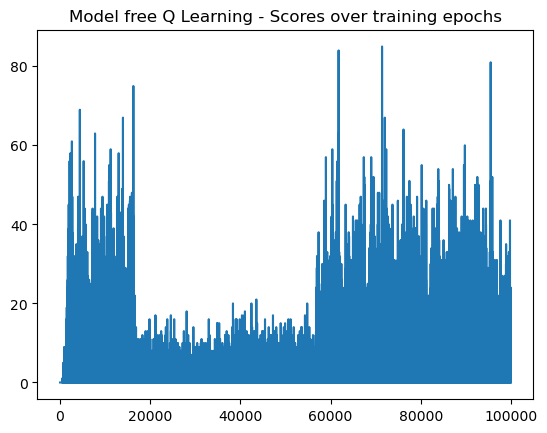

In [30]:
plt.plot(history)
plt.title("Model free Q Learning - Scores over training epochs")

In [39]:

state, info = env.reset()
    # iterate
while True:

    # Select next action
    agent.epsilon = 0
    action = agent.act(state)  # for an agent, action = agent.policy(observation)

    # Appy action and return new observation of the environment
    state, reward, done, _, info = env.step(action)

    # Render the game
    clear_output(wait= True)
    sys.stdout.write(env.render())
    time.sleep(0.15) # FPS

    # If player is dead break
    if done:
        break

    env.close()


Text Flappy Bird!
Score: 3
----------------------
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[            |       ]
[            |       ]
[            |       ]
[            |       ]
[  |                 ]
[  |                 ]
[  |                 ]
[  |                 ]
[  |         |       ]
[  |  *      |       ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=6,dy=4)


In [23]:
episodes = 200
history_dqn = []
dq_agent = DQAgent(2,2, "cpu", )
for e in tqdm(range(episodes)):

    state, _ = env.reset()
    # Play the game!
    while True:
        # Run agent on the state
        
        action = dq_agent.act(state)

        # Agent performs action
        next_state, reward, done, trunc, info = env.step(action)
        
        if done or trunc:
            next_state = None
        # Remember
        dq_agent.save_to_memory(state, next_state, action, reward,)

        # Learn
        loss = dq_agent.learn()

        # # Loggings
        # logging.info(loss)

        dq_agent.update_networks()

        # Update state
        state = next_state

        # Check if end of game
        if done or trunc:
            history_dqn.append(info['score'])
            logging.info(f"Game ended. Score = {info['score']}")
            count = 0
            break

  0%|          | 0/200 [00:00<?, ?it/s]

 84%|████████▍ | 169/200 [03:32<00:39,  1.26s/it]


KeyboardInterrupt: 

Text(0.5, 1.0, 'Score over training epochs, DQN network')

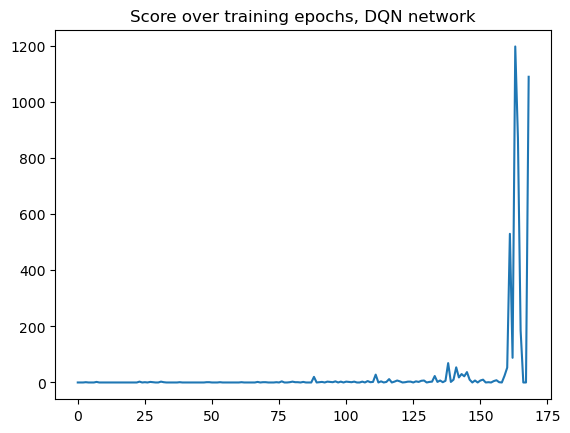

In [28]:
plt.plot(history_dqn)
plt.title("Score over training epochs, DQN network")

In [25]:
dq_agent.epsilon = 0
dq_agent.final_epsilon = 0

state, info = env.reset()
    
while True:

    # Select next action
    
    action = dq_agent.act(state)  # for an agent, action = agent.policy(observation)

    # Appy action and return new observation of the environment
    state, reward, done, _, info = env.step(action)

    # Render the game
    clear_output(wait= True)
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS

    # If player is dead break
    if done:
        break

    env.close()


Text Flappy Bird!
Score: 1229
----------------------
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      @         |   ]
[                |   ]
[                    ]
[                    ]
[      |             ]
[      |             ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=0,dy=-2)


KeyboardInterrupt: 